Setup Awal

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import KFold
import numpy as np
import os
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Transformasi gambar

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_dir = "/kaggle/input/datasetta1/Multi-Class Driver Behavior Image Dataset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Jumlah total data:", len(dataset))
print("Kelas:", dataset.classes)

Jumlah total data: 7276
Kelas: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']


Splitting dataset

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(len(train_dataset), len(val_dataset), len(test_dataset))

5820 727 729


Setup kfold=5

In [5]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

Definisikan fungsi training dan validation

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def validate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

In [7]:
num_classes = len(dataset.classes)
print("num_classes =", num_classes)

num_classes = 5


Training model mobilenet menggunakan data train

In [8]:
import time
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
import pandas as pd
import os

# === Hyperparameters ===
num_classes = len(dataset.classes)
batch_size = 32
epochs = 15
learning_rate = 1e-3
weight_decay = 1e-2
k_folds = 5

# === Folder untuk menyimpan hasil training (KHUSUS KAGGLE) ===
base_dir = "/kaggle/working"
os.makedirs(f"{base_dir}/training_logs", exist_ok=True)
os.makedirs(f"{base_dir}/saved_models", exist_ok=True)

fold_results = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
    print(f"\n========== Fold {fold+1}/{k_folds} ==========")
    fold_log = []

    train_subsampler = Subset(train_dataset, train_idx)
    val_subsampler = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False, num_workers=2)

    model = models.mobilenet_v2(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_acc = 0.0
    fold_start_time = time.time()

    log_data = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "epoch_time_sec": []
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print(f"⏱️ Waktu Epoch {epoch+1}: {epoch_time/60:.2f} menit")

        log_data["epoch"].append(epoch + 1)
        log_data["train_loss"].append(train_loss)
        log_data["train_acc"].append(train_acc)
        log_data["val_loss"].append(val_loss)
        log_data["val_acc"].append(val_acc)
        log_data["epoch_time_sec"].append(epoch_time)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{base_dir}/saved_models/best_model_fold{fold+1}.pth")

    df_log = pd.DataFrame(log_data)
    df_log.to_csv(f"{base_dir}/training_logs/training_log_fold{fold+1}.csv", index=False)
    print(f"📁 Log training fold {fold+1} disimpan ke training_logs/training_log_fold{fold+1}.csv")

    fold_end_time = time.time()
    fold_time = fold_end_time - fold_start_time
    fold_results[fold] = {"best_acc": best_acc, "fold_time": fold_time}

    print(f"\n✅ Best Val Acc for fold {fold+1}: {best_acc:.4f}")
    print(f"🕒 Total waktu training Fold {fold+1}: {fold_time/60:.2f} menit")

# === Rekap hasil akhir ===
print("\n========== K-Fold Cross Validation Results ==========")
for k, v in fold_results.items():
    print(f"Fold {k+1}: Acc={v['best_acc']:.4f} | Waktu={v['fold_time']/60:.2f} menit")

avg_acc = np.mean([v['best_acc'] for v in fold_results.values()])
total_time = np.sum([v['fold_time'] for v in fold_results.values()])

print(f"\n📊 Rata-rata Akurasi: {avg_acc:.4f}")
print(f"🕒 Total Waktu Training (semua fold): {total_time/60:.2f} menit")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



========== Fold 1/5 ==========


100%|██████████| 13.6M/13.6M [00:00<00:00, 68.4MB/s]



Epoch 1/15


Train Loss: 0.4481 | Acc: 0.8357
Val   Loss: 0.2412 | Acc: 0.9124
⏱️ Waktu Epoch 1: 1.28 menit

Epoch 2/15


Train Loss: 0.2289 | Acc: 0.9139
Val   Loss: 0.1998 | Acc: 0.9338
⏱️ Waktu Epoch 2: 0.99 menit

Epoch 3/15


Train Loss: 0.2304 | Acc: 0.9107
Val   Loss: 0.2481 | Acc: 0.9149
⏱️ Waktu Epoch 3: 0.97 menit

Epoch 4/15


Train Loss: 0.1726 | Acc: 0.9323
Val   Loss: 0.4024 | Acc: 0.8660
⏱️ Waktu Epoch 4: 0.98 menit

Epoch 5/15


Train Loss: 0.2009 | Acc: 0.9214
Val   Loss: 0.3752 | Acc: 0.8720
⏱️ Waktu Epoch 5: 1.00 menit

Epoch 6/15


Train Loss: 0.1832 | Acc: 0.9291
Val   Loss: 0.4497 | Acc: 0.8557
⏱️ Waktu Epoch 6: 0.96 menit

Epoch 7/15


Train Loss: 0.1765 | Acc: 0.9334
Val   Loss: 0.2008 | Acc: 0.9330
⏱️ Waktu Epoch 7: 0.96 menit

Epoch 8/15


Train Loss: 0.1606 | Acc: 0.9392
Val   Loss: 0.2061 | Acc: 0.9347
⏱️ Waktu Epoch 8: 0.98 menit

Epoch 9/15


Train Loss: 0.1209 | Acc: 0.9536
Val   Loss: 0.1770 | Acc: 0.9296
⏱️ Waktu Epoch 9: 0.96 menit

Epoch 10/15


Train Loss: 0.1234 | Acc: 0.9562
Val   Loss: 0.1499 | Acc: 0.9433
⏱️ Waktu Epoch 10: 0.95 menit

Epoch 11/15


Train Loss: 0.1277 | Acc: 0.9502
Val   Loss: 0.1823 | Acc: 0.9407
⏱️ Waktu Epoch 11: 0.96 menit

Epoch 12/15


Train Loss: 0.1088 | Acc: 0.9562
Val   Loss: 0.1570 | Acc: 0.9442
⏱️ Waktu Epoch 12: 0.96 menit

Epoch 13/15


Train Loss: 0.0876 | Acc: 0.9671
Val   Loss: 0.1411 | Acc: 0.9562
⏱️ Waktu Epoch 13: 0.96 menit

Epoch 14/15


Train Loss: 0.1024 | Acc: 0.9652
Val   Loss: 0.1909 | Acc: 0.9321
⏱️ Waktu Epoch 14: 0.98 menit

Epoch 15/15


Train Loss: 0.0919 | Acc: 0.9669
Val   Loss: 0.1641 | Acc: 0.9390
⏱️ Waktu Epoch 15: 0.96 menit
📁 Log training fold 1 disimpan ke training_logs/training_log_fold1.csv

✅ Best Val Acc for fold 1: 0.9562
🕒 Total waktu training Fold 1: 14.87 menit

========== Fold 2/5 ==========

Epoch 1/15


Train Loss: 0.4450 | Acc: 0.8383
Val   Loss: 0.4247 | Acc: 0.8462
⏱️ Waktu Epoch 1: 0.95 menit

Epoch 2/15


Train Loss: 0.2403 | Acc: 0.9132
Val   Loss: 0.3750 | Acc: 0.8840
⏱️ Waktu Epoch 2: 0.94 menit

Epoch 3/15


Train Loss: 0.2178 | Acc: 0.9184
Val   Loss: 0.2419 | Acc: 0.9218
⏱️ Waktu Epoch 3: 0.94 menit

Epoch 4/15


Train Loss: 0.1854 | Acc: 0.9263
Val   Loss: 0.2695 | Acc: 0.9012
⏱️ Waktu Epoch 4: 0.93 menit

Epoch 5/15


Train Loss: 0.1829 | Acc: 0.9323
Val   Loss: 0.2201 | Acc: 0.9132
⏱️ Waktu Epoch 5: 0.94 menit

Epoch 6/15


Train Loss: 0.1538 | Acc: 0.9394
Val   Loss: 0.1984 | Acc: 0.9227
⏱️ Waktu Epoch 6: 0.92 menit

Epoch 7/15


Train Loss: 0.1683 | Acc: 0.9345
Val   Loss: 0.2241 | Acc: 0.9175
⏱️ Waktu Epoch 7: 0.95 menit

Epoch 8/15


Train Loss: 0.1706 | Acc: 0.9332
Val   Loss: 0.2076 | Acc: 0.9244
⏱️ Waktu Epoch 8: 0.97 menit

Epoch 9/15


Train Loss: 0.1190 | Acc: 0.9536
Val   Loss: 0.1609 | Acc: 0.9381
⏱️ Waktu Epoch 9: 0.95 menit

Epoch 10/15


Train Loss: 0.1059 | Acc: 0.9583
Val   Loss: 0.1538 | Acc: 0.9476
⏱️ Waktu Epoch 10: 0.95 menit

Epoch 11/15


Train Loss: 0.1074 | Acc: 0.9555
Val   Loss: 0.1961 | Acc: 0.9270
⏱️ Waktu Epoch 11: 0.94 menit

Epoch 12/15


Train Loss: 0.1557 | Acc: 0.9470
Val   Loss: 0.2589 | Acc: 0.9081
⏱️ Waktu Epoch 12: 0.96 menit

Epoch 13/15


Train Loss: 0.1173 | Acc: 0.9573
Val   Loss: 0.2133 | Acc: 0.9192
⏱️ Waktu Epoch 13: 0.94 menit

Epoch 14/15


Train Loss: 0.1136 | Acc: 0.9564
Val   Loss: 0.1899 | Acc: 0.9287
⏱️ Waktu Epoch 14: 0.93 menit

Epoch 15/15


Train Loss: 0.0947 | Acc: 0.9633
Val   Loss: 0.1474 | Acc: 0.9442
⏱️ Waktu Epoch 15: 0.95 menit
📁 Log training fold 2 disimpan ke training_logs/training_log_fold2.csv

✅ Best Val Acc for fold 2: 0.9476
🕒 Total waktu training Fold 2: 14.18 menit

========== Fold 3/5 ==========

Epoch 1/15


Train Loss: 0.4740 | Acc: 0.8185
Val   Loss: 0.2113 | Acc: 0.9107
⏱️ Waktu Epoch 1: 0.98 menit

Epoch 2/15


Train Loss: 0.2358 | Acc: 0.9119
Val   Loss: 0.4294 | Acc: 0.8419
⏱️ Waktu Epoch 2: 0.94 menit

Epoch 3/15


Train Loss: 0.2230 | Acc: 0.9145
Val   Loss: 0.2548 | Acc: 0.9064
⏱️ Waktu Epoch 3: 0.96 menit

Epoch 4/15


Train Loss: 0.2075 | Acc: 0.9197
Val   Loss: 0.2102 | Acc: 0.9210
⏱️ Waktu Epoch 4: 0.96 menit

Epoch 5/15


Train Loss: 0.1927 | Acc: 0.9227
Val   Loss: 0.2273 | Acc: 0.9192
⏱️ Waktu Epoch 5: 0.95 menit

Epoch 6/15


Train Loss: 0.1721 | Acc: 0.9285
Val   Loss: 0.1879 | Acc: 0.9227
⏱️ Waktu Epoch 6: 0.94 menit

Epoch 7/15


Train Loss: 0.1697 | Acc: 0.9315
Val   Loss: 0.2004 | Acc: 0.9235
⏱️ Waktu Epoch 7: 0.97 menit

Epoch 8/15


Train Loss: 0.1521 | Acc: 0.9358
Val   Loss: 0.1868 | Acc: 0.9313
⏱️ Waktu Epoch 8: 0.93 menit

Epoch 9/15


Train Loss: 0.1612 | Acc: 0.9403
Val   Loss: 0.1877 | Acc: 0.9313
⏱️ Waktu Epoch 9: 0.94 menit

Epoch 10/15


Train Loss: 0.1618 | Acc: 0.9364
Val   Loss: 0.4386 | Acc: 0.8729
⏱️ Waktu Epoch 10: 0.95 menit

Epoch 11/15


Train Loss: 0.1549 | Acc: 0.9362
Val   Loss: 0.1910 | Acc: 0.9296
⏱️ Waktu Epoch 11: 0.97 menit

Epoch 12/15


Train Loss: 0.1200 | Acc: 0.9519
Val   Loss: 0.1733 | Acc: 0.9399
⏱️ Waktu Epoch 12: 0.93 menit

Epoch 13/15


Train Loss: 0.1356 | Acc: 0.9474
Val   Loss: 0.1877 | Acc: 0.9287
⏱️ Waktu Epoch 13: 0.97 menit

Epoch 14/15


Train Loss: 0.1541 | Acc: 0.9446
Val   Loss: 0.3894 | Acc: 0.8780
⏱️ Waktu Epoch 14: 0.94 menit

Epoch 15/15


Train Loss: 0.1366 | Acc: 0.9480
Val   Loss: 0.1678 | Acc: 0.9364
⏱️ Waktu Epoch 15: 0.95 menit
📁 Log training fold 3 disimpan ke training_logs/training_log_fold3.csv

✅ Best Val Acc for fold 3: 0.9399
🕒 Total waktu training Fold 3: 14.29 menit

========== Fold 4/5 ==========

Epoch 1/15


Train Loss: 0.4330 | Acc: 0.8342
Val   Loss: 0.3912 | Acc: 0.8703
⏱️ Waktu Epoch 1: 0.96 menit

Epoch 2/15


Train Loss: 0.2308 | Acc: 0.9145
Val   Loss: 0.2200 | Acc: 0.9227
⏱️ Waktu Epoch 2: 0.96 menit

Epoch 3/15


Train Loss: 0.1978 | Acc: 0.9218
Val   Loss: 0.2537 | Acc: 0.9098
⏱️ Waktu Epoch 3: 0.96 menit

Epoch 4/15


Train Loss: 0.1902 | Acc: 0.9255
Val   Loss: 0.2538 | Acc: 0.9158
⏱️ Waktu Epoch 4: 0.99 menit

Epoch 5/15


Train Loss: 0.1891 | Acc: 0.9248
Val   Loss: 0.2065 | Acc: 0.9235
⏱️ Waktu Epoch 5: 0.97 menit

Epoch 6/15


Train Loss: 0.1810 | Acc: 0.9304
Val   Loss: 0.3101 | Acc: 0.8900
⏱️ Waktu Epoch 6: 0.98 menit

Epoch 7/15


Train Loss: 0.1757 | Acc: 0.9304
Val   Loss: 0.2121 | Acc: 0.9244
⏱️ Waktu Epoch 7: 0.95 menit

Epoch 8/15


Train Loss: 0.1689 | Acc: 0.9364
Val   Loss: 0.3663 | Acc: 0.8978
⏱️ Waktu Epoch 8: 0.96 menit

Epoch 9/15


Train Loss: 0.1378 | Acc: 0.9422
Val   Loss: 0.2145 | Acc: 0.9287
⏱️ Waktu Epoch 9: 0.97 menit

Epoch 10/15


Train Loss: 0.1266 | Acc: 0.9467
Val   Loss: 0.2383 | Acc: 0.9218
⏱️ Waktu Epoch 10: 0.95 menit

Epoch 11/15


Train Loss: 0.1602 | Acc: 0.9384
Val   Loss: 0.3071 | Acc: 0.9149
⏱️ Waktu Epoch 11: 0.97 menit

Epoch 12/15


Train Loss: 0.1431 | Acc: 0.9439
Val   Loss: 0.2470 | Acc: 0.9149
⏱️ Waktu Epoch 12: 0.94 menit

Epoch 13/15


Train Loss: 0.1128 | Acc: 0.9562
Val   Loss: 0.2064 | Acc: 0.9287
⏱️ Waktu Epoch 13: 0.93 menit

Epoch 14/15


Train Loss: 0.1134 | Acc: 0.9566
Val   Loss: 0.3090 | Acc: 0.8832
⏱️ Waktu Epoch 14: 0.94 menit

Epoch 15/15


Train Loss: 0.1283 | Acc: 0.9534
Val   Loss: 0.1856 | Acc: 0.9287
⏱️ Waktu Epoch 15: 0.97 menit
📁 Log training fold 4 disimpan ke training_logs/training_log_fold4.csv

✅ Best Val Acc for fold 4: 0.9287
🕒 Total waktu training Fold 4: 14.42 menit

========== Fold 5/5 ==========

Epoch 1/15


Train Loss: 0.4316 | Acc: 0.8424
Val   Loss: 0.2831 | Acc: 0.8926
⏱️ Waktu Epoch 1: 0.98 menit

Epoch 2/15


Train Loss: 0.2432 | Acc: 0.9061
Val   Loss: 0.3260 | Acc: 0.8737
⏱️ Waktu Epoch 2: 0.94 menit

Epoch 3/15


Train Loss: 0.2209 | Acc: 0.9190
Val   Loss: 0.2421 | Acc: 0.9089
⏱️ Waktu Epoch 3: 0.95 menit

Epoch 4/15


Train Loss: 0.1743 | Acc: 0.9330
Val   Loss: 0.6852 | Acc: 0.7878
⏱️ Waktu Epoch 4: 0.93 menit

Epoch 5/15


Train Loss: 0.1830 | Acc: 0.9313
Val   Loss: 0.2421 | Acc: 0.9141
⏱️ Waktu Epoch 5: 0.96 menit

Epoch 6/15


Train Loss: 0.1866 | Acc: 0.9291
Val   Loss: 0.4026 | Acc: 0.8625
⏱️ Waktu Epoch 6: 0.96 menit

Epoch 7/15


Train Loss: 0.1530 | Acc: 0.9409
Val   Loss: 0.4016 | Acc: 0.8462
⏱️ Waktu Epoch 7: 0.94 menit

Epoch 8/15


Train Loss: 0.1443 | Acc: 0.9427
Val   Loss: 0.2128 | Acc: 0.9175
⏱️ Waktu Epoch 8: 0.95 menit

Epoch 9/15


Train Loss: 0.1538 | Acc: 0.9418
Val   Loss: 0.2493 | Acc: 0.9115
⏱️ Waktu Epoch 9: 0.95 menit

Epoch 10/15


Train Loss: 0.1283 | Acc: 0.9500
Val   Loss: 0.1795 | Acc: 0.9338
⏱️ Waktu Epoch 10: 0.97 menit

Epoch 11/15


Train Loss: 0.1240 | Acc: 0.9532
Val   Loss: 0.1682 | Acc: 0.9330
⏱️ Waktu Epoch 11: 0.97 menit

Epoch 12/15


Train Loss: 0.1418 | Acc: 0.9497
Val   Loss: 0.2403 | Acc: 0.9175
⏱️ Waktu Epoch 12: 0.96 menit

Epoch 13/15


Train Loss: 0.1313 | Acc: 0.9521
Val   Loss: 0.1915 | Acc: 0.9321
⏱️ Waktu Epoch 13: 0.96 menit

Epoch 14/15


Train Loss: 0.1050 | Acc: 0.9613
Val   Loss: 0.1745 | Acc: 0.9338
⏱️ Waktu Epoch 14: 0.97 menit

Epoch 15/15


Train Loss: 0.0854 | Acc: 0.9676
Val   Loss: 0.1994 | Acc: 0.9287
⏱️ Waktu Epoch 15: 0.98 menit
📁 Log training fold 5 disimpan ke training_logs/training_log_fold5.csv

✅ Best Val Acc for fold 5: 0.9338
🕒 Total waktu training Fold 5: 14.38 menit

========== K-Fold Cross Validation Results ==========
Fold 1: Acc=0.9562 | Waktu=14.87 menit
Fold 2: Acc=0.9476 | Waktu=14.18 menit
Fold 3: Acc=0.9399 | Waktu=14.29 menit
Fold 4: Acc=0.9287 | Waktu=14.42 menit
Fold 5: Acc=0.9338 | Waktu=14.38 menit

📊 Rata-rata Akurasi: 0.9412
🕒 Total Waktu Training (semua fold): 72.14 menit


Evaluasi rata-rata kfold

In [9]:
import numpy as np

print("\n=== HASIL K-FOLD CROSS VALIDATION ===")
for fold, acc in fold_results.items():
    print(f"Fold {fold+1}: {acc['best_acc']:.4f}")

mean_acc = np.mean([v['best_acc'] for v in fold_results.values()])
print(f"\nRata-rata akurasi K-Fold: {mean_acc:.4f}")


=== HASIL K-FOLD CROSS VALIDATION ===
Fold 1: 0.9562
Fold 2: 0.9476
Fold 3: 0.9399
Fold 4: 0.9287
Fold 5: 0.9338

Rata-rata akurasi K-Fold: 0.9412


Final testing menggunakan data test

In [11]:
# Path lengkap model yang disimpan di cloud
model_path = "/kaggle/working/saved_models/best_model_fold1.pth"

# Load model terbaik
best_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
best_model.classifier[1] = nn.Linear(best_model.last_channel, num_classes)
best_model.load_state_dict(torch.load(model_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

# Evaluasi di test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_acc = validate(best_model, test_loader, criterion)

print(f"\nEvaluasi di TEST SET (10%):")
print(f"Loss: {test_loss:.4f} | Akurasi: {test_acc:.4f}")


Evaluasi di TEST SET (10%):
Loss: 0.2198 | Akurasi: 0.9191


Visualisasi akurasi tiap fold

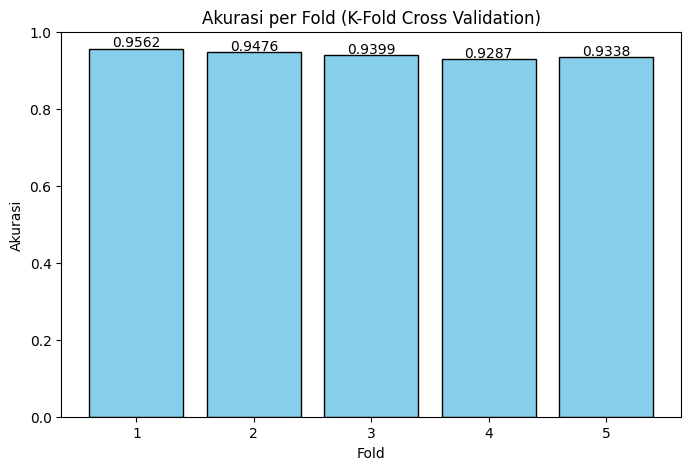


=== RINGKASAN HASIL K-FOLD ===
Fold 1: Akurasi = 0.9562 | Waktu = 14.87 menit
Fold 2: Akurasi = 0.9476 | Waktu = 14.18 menit
Fold 3: Akurasi = 0.9399 | Waktu = 14.29 menit
Fold 4: Akurasi = 0.9287 | Waktu = 14.42 menit
Fold 5: Akurasi = 0.9338 | Waktu = 14.38 menit

Rata-rata Akurasi: 0.9412
Rata-rata Waktu per Fold: 14.43 menit


In [12]:
import matplotlib.pyplot as plt

# Ambil nomor fold
folds = [f + 1 for f in fold_results.keys()]

# Ambil nilai akurasi dari key 'best_acc'
accuracies = [v['best_acc'] for v in fold_results.values()]

# (Opsional) ambil juga waktu training per fold
times = [v['fold_time'] / 60 for v in fold_results.values()]  # ubah jadi menit

# --- Buat grafik akurasi ---
plt.figure(figsize=(8,5))
plt.bar(folds, accuracies, color='skyblue', edgecolor='black')
plt.title("Akurasi per Fold (K-Fold Cross Validation)")
plt.xlabel("Fold")
plt.ylabel("Akurasi")
plt.ylim(0, 1)

# Tambahkan label nilai di atas bar
for i, acc in enumerate(accuracies):
    plt.text(folds[i], acc + 0.005, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()

# --- Cetak statistik tambahan ---
print("\n=== RINGKASAN HASIL K-FOLD ===")
for f, (acc, t) in enumerate(zip(accuracies, times)):
    print(f"Fold {f+1}: Akurasi = {acc:.4f} | Waktu = {t:.2f} menit")

print(f"\nRata-rata Akurasi: {np.mean(accuracies):.4f}")
print(f"Rata-rata Waktu per Fold: {np.mean(times):.2f} menit")